In [0]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
%matplotlib inline

In [0]:
#Количество подпроцессов для загрузки данных
num_workers = 0
#Сколько образцов загружаем за раз
batch_size = 64
#Конвертируем в тензор
transform = transforms.ToTensor()

#Загружаем данные
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)


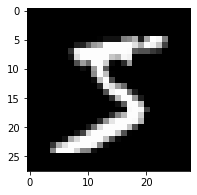

In [3]:
#Визуализируем
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

#Берем одну картинку с батча
img = np.squeeze(images[0])
fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [0]:
import torch.nn as nn
import torch.nn.functional as F
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(input_size, hidden_dim*4))
        self.fc2 = nn.Sequential(nn.Linear(hidden_dim*4, hidden_dim*2))
        self.fc3 = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim))
        self.fc4 = nn.Sequential(nn.Linear(hidden_dim, output_size))
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = self.fc4(x)
        return x


In [0]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()       
        self.fc1 = nn.Sequential(nn.Linear(input_size, hidden_dim))
        self.fc2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim*2))
        self.fc3 = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim*4))
        self.fc4 = nn.Sequential(nn.Linear(hidden_dim*4, output_size))
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        #x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        #x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        #x = F.dropout(x, 0.3)
        x = F.tanh(self.fc4(x))

        return x

In [0]:
#Параметры дискрименатора
input_size = 28*28
d_output_size = 1
d_hidden_size = 32
#Параметры генератора
z_size = 100
g_output_size = 28*28
g_hidden_size = 32

In [0]:
#Построение сетей
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

In [8]:
#Посмотрим верно ли подобрали параметры 
print(D)
print()
print(G)

Discriminator(
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
  )
  (fc3): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
  )
  (fc4): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
  )
)

Generator(
  (fc1): Sequential(
    (0): Linear(in_features=100, out_features=32, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
  )
  (fc3): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
  )
  (fc4): Sequential(
    (0): Linear(in_features=128, out_features=784, bias=True)
  )
)


In [0]:
#Функции подсчета ошибок
def real_loss(D_out, smooth=False):
  batch_size = D_out.size(0)
  if smooth:
    labels = torch.ones(batch_size) * 0.9
  else:
    labels = torch.ones(batch_size) 
  criterion = nn.BCEWithLogitsLoss()
  labels = Variable(labels)
  labels = labels.cuda() 
  loss = criterion(D_out.squeeze(),labels)
  #loss = loss.float()
  return loss

def fake_loss(D_out):
  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size)
  criterion = nn.BCEWithLogitsLoss()
  labels = Variable(labels)
  labels = labels.cuda() 
  loss = criterion(D_out.squeeze(),labels)
  return loss

In [0]:
#Определим 2 разных оптимизатора для генераторая и дискрименатора
import torch.optim as optim

lr = 0.002
d_optimizer = optim.Adam(D.parameters(),lr= lr, betas=(0.3, 0.999))
g_optimizer = optim.Adam(G.parameters(),lr= lr, betas=(0.3, 0.999))

In [11]:
#Обучение
import pickle as pkl

num_epochs = 40
samples = []
losses = []
print_every = 400
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_z = fixed_z.cuda()
D.train()
G.train()
D.cuda()
G.cuda()
for epoch in range(num_epochs):
  for batch_i, (real_images, _) in enumerate(train_loader):
    batch_size = real_images.size(0)
    ## Important rescaling step ##
    real_images = real_images*2 - 1
    #real_images = real_images.view(-1, input_size)
    
    real_images = Variable(real_images)
    real_images = real_images.cuda()
    #Обучаем дискременатор сразу на реальных и фейковых картинках
    d_optimizer.zero_grad()
    #Обучение с реальными картинками
    D_real = D(real_images)
    d_real_loss = real_loss(D_real, smooth=True)
    #Обучение на фейковых картинках
    #Генерация фейковых картинок
    z = np.random.uniform(-1,1,size = (batch_size, z_size))
    z = torch.from_numpy(z).float()
    z = Variable(z)
    z = z.cuda()

    fake_images = G(z)
    D_fake = D(fake_images)
    d_fake_loss = fake_loss(D_fake)
    
    d_loss = d_fake_loss + d_real_loss

    d_loss.backward()
    d_optimizer.step()
    
    
    #Обучаем генератор
    g_optimizer.zero_grad()

    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()
    z = Variable(z)
    z = z.cuda()

    fake_images = G(z)

    D_fake = D(fake_images)
    g_loss = real_loss(D_fake)

    g_loss.backward()
    g_optimizer.step()

    if batch_i % print_every == 0:    
      print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
              epoch+1, num_epochs, d_loss.item(), g_loss.item()))

  losses.append((d_loss.item(), g_loss.item()))
  G.eval()
  samples_z = G(fixed_z)
  samples.append(samples_z)
  G.train()

with open('train_samples.pkl', 'wb') as f:
  pkl.dump(samples, f)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   40] | d_loss: 1.4104 | g_loss: 0.6311
Epoch [    1/   40] | d_loss: 1.2701 | g_loss: 1.2768
Epoch [    1/   40] | d_loss: 1.1541 | g_loss: 1.3325
Epoch [    2/   40] | d_loss: 1.9057 | g_loss: 0.7322
Epoch [    2/   40] | d_loss: 1.1829 | g_loss: 1.0958
Epoch [    2/   40] | d_loss: 1.1156 | g_loss: 1.4167
Epoch [    3/   40] | d_loss: 1.1163 | g_loss: 1.2367
Epoch [    3/   40] | d_loss: 1.1476 | g_loss: 1.1547
Epoch [    3/   40] | d_loss: 1.1338 | g_loss: 1.6994
Epoch [    4/   40] | d_loss: 1.3874 | g_loss: 0.6962
Epoch [    4/   40] | d_loss: 1.1256 | g_loss: 0.9963
Epoch [    4/   40] | d_loss: 1.2179 | g_loss: 1.1219
Epoch [    5/   40] | d_loss: 1.2444 | g_loss: 0.9975
Epoch [    5/   40] | d_loss: 1.1166 | g_loss: 1.0561
Epoch [    5/   40] | d_loss: 1.1557 | g_loss: 1.4879
Epoch [    6/   40] | d_loss: 1.3926 | g_loss: 2.0829
Epoch [    6/   40] | d_loss: 1.2540 | g_loss: 1.0906
Epoch [    6/   40] | d_loss: 1.1860 | g_loss: 1.4989
Epoch [    7/   40] | d_loss

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


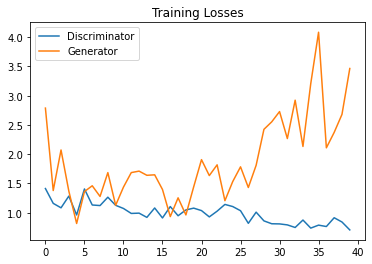

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [0]:
def view_samples(epoch, samples):
  fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
  for ax, img in zip(axes.flatten(), samples[epoch]):
    img = img.detach()
    img = img.cpu()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [0]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
  samples = pkl.load(f)

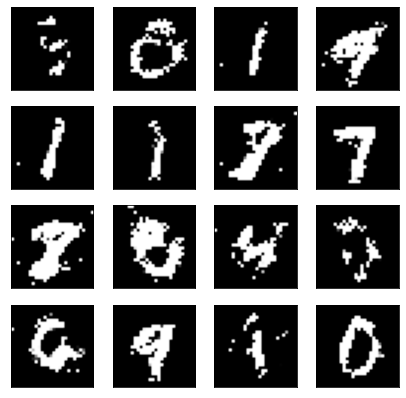

In [15]:
view_samples(-1, samples)

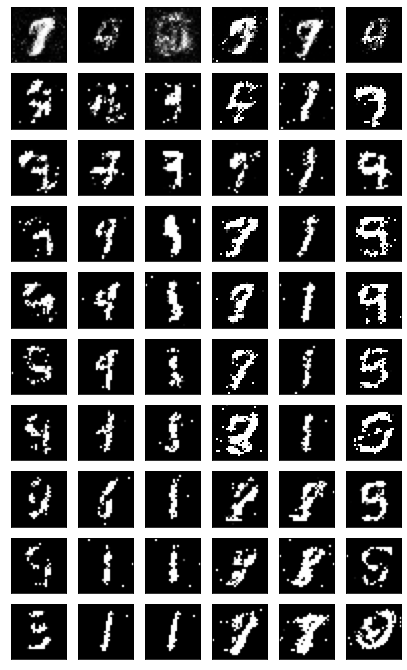

In [16]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)
for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
  for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
    img = img.detach()
    img = img.cpu()
    ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


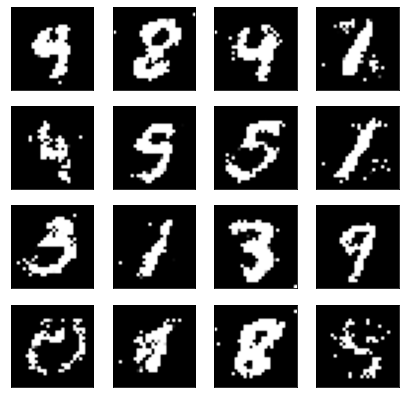

In [17]:
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()
rand_z = rand_z.cuda()
G.eval() # eval mode
# generated samples
rand_images = G(rand_z)
# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])